### Setup and imports

In [156]:
import time
import itertools

import numpy as np
import scipy as sp
import scipy.stats
import tensorflow as tf
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation
%matplotlib inline
import seaborn as sb
from IPython.display import HTML, display

from gcn.models import GCN
from gcn import utils as gcn_utils

#mpl.rc('animation', embed_limit=50 * 1024 * 1024) # In bytes; default limit in 20MB
VID = 'animations/l={l}-k={k}-p_inner={p_inner}-p_outer={p_outer}-f_mult={f_mult}-f_sigma={f_sigma}.mp4'

### Network drawing routines

In [107]:
def network_colors(g, labels, ref_labels=None, training_nodes=[], lmin=0.0, lmax=1.0):
    if ref_labels is None:
        ref_labels = labels
    
    # Generate colormap
    cmap = mpl.cm.get_cmap('viridis')
    norm = mpl.colors.Normalize(vmin=lmin, vmax=lmax)
    cats = np.array(sb.color_palette(n_colors=labels.shape[1]))
    
    # Compute colors
    node_colors = cats[np.argmax(labels, 1)]
    node_colors[training_nodes] = [0, 0, 0]
    edgecolors = cmap(norm(labels[range(labels.shape[0]), np.argmax(ref_labels, 1)]))
    
    return node_colors, edgecolors

_network_layouts = {}
def draw_network(g, labels=None, training_nodes=[], lmin=0.0, lmax=1.0, ax=None, relayout=False):
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))
    else:
        fig = ax.figure
    
    if relayout or g not in _network_layouts:
        _network_layouts[g] = nx.drawing.layout.spring_layout(g)
    layout = _network_layouts[g]
    
    if labels is None:
        assert len(ref_nodes) == 0
        nx.draw_networkx(g, pos=layout, ax=ax, node_color='#65cb5e')
        node_collection = None
        edge_collection = None
        text_items = None
    else:
        assert l is not None
        assert k is not None
        # Plot nodes, edges and labels
        node_colors, edgecolors = network_colors(g, labels, training_nodes=training_nodes,
                                                 lmin=lmin, lmax=lmax)
        node_collection = nx.draw_networkx_nodes(g, pos=layout, ax=ax,
                                                 node_color=node_colors,
                                                 edgecolors=edgecolors,
                                                 linewidths=2)
        edge_collection = nx.draw_networkx_edges(g, pos=layout, ax=ax)
        text_items = nx.draw_networkx_labels(g, pos=layout, font_color='#e4e4e4', ax=ax)
        
        # Add the colorbar
        color_sm = plt.cm.ScalarMappable(cmap='viridis', norm=mpl.colors.Normalize(vmin=lmin, vmax=lmax))
        color_sm.set_array([])
        fig.colorbar(color_sm)
    
    return (fig, ax), (node_collection, edge_collection, text_items)

### Try out feature randomisation

In [3]:
def feature_sample(mode, scale=.2, size=None):
    #α = alpha
    #β = (α - 1) / mode - α + 2
    #return np.random.beta(α, β, size=size)
    return np.random.normal(mode, scale, size=size)

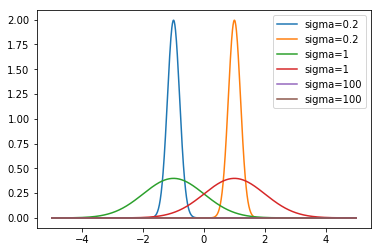

In [4]:
for sigma in [.2, 1, 100]:
    x = np.linspace(-5, 5, 1000)
    np.c_
    plt.plot(x, np.c_[scipy.stats.norm.pdf(x, -1, sigma), scipy.stats.norm.pdf(x, 1, sigma)],
             label='sigma={}'.format(sigma))
    #plt.hist(feature_sample(1, i, size=1000), normed=True, bins=50, alpha=.6)
plt.legend()

### GCN training setup

#### Initial setup

Base options for the model

In [5]:
flags = tf.app.flags
flags.DEFINE_float('learning_rate', 0.01, 'Initial learning rate.')
flags.DEFINE_integer('epochs', 200, 'Number of epochs to train.')
flags.DEFINE_integer('hidden1', 16, 'Number of units in hidden layer 1.')
flags.DEFINE_float('dropout', 0, #0.5,
                   'Dropout rate (1 - keep probability).')
flags.DEFINE_float('weight_decay', 0, #5e-4,
                   'Weight for L2 loss on embedding matrix.')
flags.DEFINE_integer('early_stopping', 10, 'Tolerance for early stopping (# of epochs).')

In [6]:
def initialise_arrays(labels, mult, sigma, training_nodes):
    # Generate initial noised features
    features_noise = np.stack([np.concatenate([feature_sample(2 * v - 1, scale=sigma, size=mult)
                                               for v in label_values])
                               for label_values in labels])
    features = gcn_utils.preprocess_features(sp.sparse.lil_matrix(features_noise))

    # Generate training and validation arrays
    train_mask = gcn_utils.sample_mask(training_nodes, labels.shape[0])
    val_mask = np.logical_not(train_mask)

    labels_train = np.zeros(labels.shape)
    labels_val = np.zeros(labels.shape)

    labels_train[train_mask, :] = labels[train_mask, :]
    labels_val[val_mask, :] = labels[val_mask, :]
    
    return {
        'features': features,
        'train_mask': train_mask,
        'val_mask': val_mask,
        'labels': labels,
        'labels_train': labels_train,
        'labels_val': labels_val,
    }

In [7]:
def initialise_model_session(g, labels, mult, sigma, training_nodes):
    arrays = initialise_arrays(labels, mult, sigma, training_nodes)
    
    # Finish parameterising the model
    support = [gcn_utils.preprocess_adj(nx.adjacency_matrix(g))]
    placeholders = {
        'support': [tf.sparse_placeholder(tf.float32) for _ in range(len(support))],
        'features': tf.sparse_placeholder(tf.float32, shape=tf.constant(arrays['features'][2], dtype=tf.int64)),
        'labels': tf.placeholder(tf.float32, shape=(None, arrays['labels_train'].shape[1])),
        'labels_mask': tf.placeholder(tf.int32),
        'dropout': tf.placeholder_with_default(0., shape=()),
        'num_features_nonzero': tf.placeholder(tf.int32)  # helper variable for sparse dropout
    }
    arrays['support'] = support
    arrays['placeholders'] = placeholders
    
    model = GCN(placeholders, input_dim=arrays['features'][2][1], logging=True)
    session = tf.Session()
    session.run(tf.global_variables_initializer())
    
    return model, arrays, session

In [8]:
def evaluate_model(model, arrays, session):
    t_test = time.time()
    feed_dict_val = gcn_utils.construct_feed_dict(arrays['features'], arrays['support'],
                                                  arrays['labels_val'], arrays['val_mask'],
                                                  arrays['placeholders'])
    outs_val = session.run([model.loss, model.accuracy], feed_dict=feed_dict_val)
    return outs_val[0], outs_val[1], (time.time() - t_test)

def model_predict(model, arrays, session):
    feed_dict_pred = gcn_utils.construct_feed_dict(arrays['features'], arrays['support'],
                                                   arrays['labels'], np.ones(arrays['labels'].shape[0]),
                                                   arrays['placeholders'])
    return session.run(model.predict(), feed_dict=feed_dict_pred)

#### Model training

In [108]:
def legend_text(epoch, t, train_loss, train_acc, val_loss, val_acc):
    return ("epoch: {:4d} time={:.5f}\n"
            "train_loss={:.5f} train_acc={:.5f}\n"
            "val_loss={:.5f} val_acc={:.5f}\n").format(epoch, time.time() - t,
                                                       train_loss, train_acc, val_loss, val_acc)

def build_train_animation(glk, labels, mult, sigma,
                          training_nodes=None, community_training_pct=.2,
                          log=True):    
    if training_nodes is None:
        g, l, k = glk
        trains_per_cty = int(np.round(k * community_training_pct))
        training_nodes = np.concatenate([np.random.choice(range(c * k, (c + 1) * k),
                                                          trains_per_cty, replace=False)
                                         for c in range(l)])
    else:
        g = glk
    
    # Get the model
    model, arrays, session = initialise_model_session(g, labels, mult, sigma, training_nodes)
    
    # Prepare plotting
    (fig, ax), (node_collection, _, _) = draw_network(g, labels=labels,
                                                      training_nodes=np.where(arrays['train_mask'])[0])
    legend = ax.text(.5, 1, legend_text(0, 0, 0, 0, 0, 0),
                     ha='center', va='bottom', transform=ax.transAxes,
                     bbox=dict(facecolor='white', alpha=0.8))
    
    def init_plot():
        legend.set_text(legend_text(0, 0, 0, 0, 0, 0))
        node_collection.set_color(np.zeros((labels.shape[0], 4)))
        node_collection.set_edgecolors(np.zeros((labels.shape[0], 4)))
        return node_collection, legend

    cost_val = []
    def train_step(frame):
        t = time.time()

        feed_dict = gcn_utils.construct_feed_dict(arrays['features'], arrays['support'],
                                                  arrays['labels_train'], arrays['train_mask'],
                                                  arrays['placeholders'])
        feed_dict.update({arrays['placeholders']['dropout']: flags.FLAGS.dropout})

        outs = session.run([model.opt_op, model.loss, model.accuracy], feed_dict=feed_dict)
        cost, acc, duration = evaluate_model(model, arrays, session)
        cost_val.append(cost)

        if log:
            print("Epoch:", '%04d' % (frame + 1), "train_loss={:.5f}".format(outs[1]),
                  "train_acc={:.5f}".format(outs[2]), "val_loss={:.5f}".format(cost),
                  "val_acc={:.5f}".format(acc), "time={:.5f}".format(time.time() - t))
        
        legend.set_text(legend_text(frame, t, outs[1], outs[2], cost, acc))
        
        preds = model_predict(model, arrays, session)
        node_colors, edgecolors = network_colors(g, preds,
                                                 ref_labels=labels,
                                                 training_nodes=np.where(arrays['train_mask'])[0])
        node_collection.set_color(node_colors)
        node_collection.set_edgecolors(edgecolors)

        return node_collection, legend

    def model_frames():
        counter = 0
        while True:
            if (counter > flags.FLAGS.early_stopping and
                    cost_val[-1] > np.mean(cost_val[-(flags.FLAGS.early_stopping+1):-1])):
                if log:
                    print("Early stopping.")
                return
            else:
                yield counter
                counter += 1

    anim = mpl.animation.FuncAnimation(fig, train_step, blit=True,
                                       init_func=init_plot,
                                       interval=100,
                                       save_count=flags.FLAGS.epochs,
                                       frames=model_frames(),
                                       repeat=False)
    plt.close()
    return anim, (model, arrays, session)

### Test random graphs

**Random graphs generators:**
* [Planted Partition](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.generators.community.planted_partition_graph.html#networkx.generators.community.planted_partition_graph)
* [Lancichinetti–Fortunato–Radicchi benchmark](https://en.wikipedia.org/wiki/Lancichinetti%E2%80%93Fortunato%E2%80%93Radicchi_benchmark)

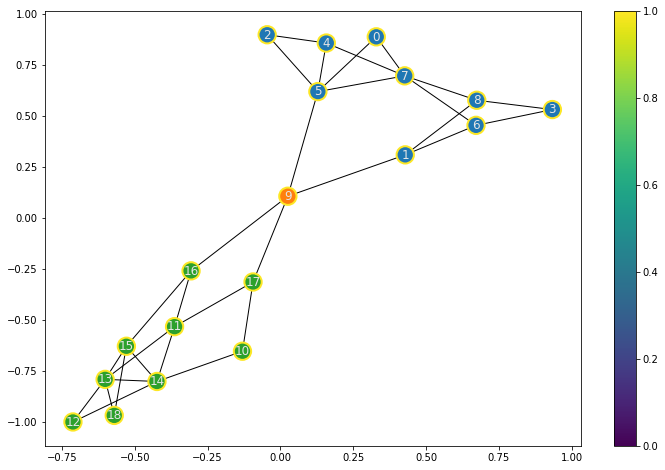

In [197]:
# Parameters
l1, l2, li = (10, 10, 1)
p_inner = .4
feature_mult = 1
feature_sigma = .2

# Show the graph
g1 = nx.planted_partition_graph(1, l1, p_inner, 0)
g2 = nx.relabel_nodes(nx.planted_partition_graph(1, l2, p_inner, 0),
                      {i: i + l1 - li for i in range(l2)})
g2.remove_edges_from(itertools.product(range(l1 - li, l1), repeat=2))
g = nx.compose(g1, g2)
labels = np.zeros((l1 + l2 - li, 3))
labels[:l1 - li, 0] = 1
labels[l1 - li:l1, 1] = 1
labels[l1:l1 + l2 - li, 2] = 1
draw_network(g, labels=labels);

In [198]:
# Training nodes
trains_per_cty = 1
training_nodes = np.concatenate([np.random.choice(range(l1 - li), trains_per_cty, replace=False),
                                 np.random.choice(range(l1, l1 + l2 - li), trains_per_cty, replace=False)])

# Animate training
filename = VID.format(l='{}|{}|{}'.format(l1, l2, li), k=3, p_inner=p_inner, p_outer=0,
                      f_mult=feature_mult, f_sigma=feature_sigma)
anim, (model, arrays, session) = build_train_animation(g, labels, feature_mult, feature_sigma,
                                                       training_nodes=training_nodes)
widget = anim.save(filename)
#.to_jshtml()
#.to_html5_video()
#display(HTML(widget))
print("Animation saved to '{}'".format(filename))

Epoch: 0001 train_loss=1.47159 train_acc=0.00000 val_loss=1.23783 val_acc=0.00000 time=0.07547
Epoch: 0002 train_loss=1.33263 train_acc=0.00000 val_loss=1.15008 val_acc=0.00000 time=0.00259
Epoch: 0003 train_loss=1.20160 train_acc=0.00000 val_loss=1.06731 val_acc=0.00000 time=0.00256
Epoch: 0004 train_loss=1.07988 train_acc=0.00000 val_loss=0.99055 val_acc=0.58824 time=0.00182
Epoch: 0005 train_loss=0.97015 train_acc=0.50000 val_loss=0.92226 val_acc=0.94118 time=0.00354
Epoch: 0006 train_loss=0.87535 train_acc=1.00000 val_loss=0.86009 val_acc=0.94118 time=0.00685
Epoch: 0007 train_loss=0.79157 train_acc=1.00000 val_loss=0.80150 val_acc=0.94118 time=0.00168
Epoch: 0008 train_loss=0.71438 train_acc=1.00000 val_loss=0.74617 val_acc=0.94118 time=0.00162
Epoch: 0009 train_loss=0.64342 train_acc=1.00000 val_loss=0.69388 val_acc=0.94118 time=0.00245
Epoch: 0010 train_loss=0.57793 train_acc=1.00000 val_loss=0.64453 val_acc=0.94118 time=0.00315
Epoch: 0011 train_loss=0.51757 train_acc=1.00000 v

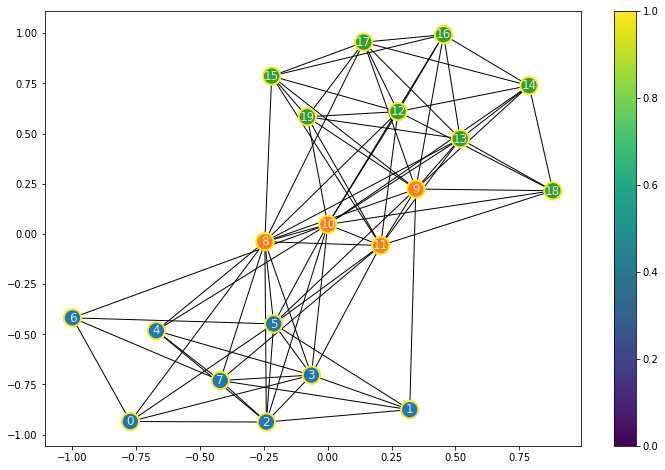

In [195]:
# Parameters
l1, l2, li = (12, 12, 4)
p_inner = .6
feature_mult = 1
feature_sigma = .2

# Show the graph
g1 = nx.planted_partition_graph(1, l1, p_inner, 0)
g2 = nx.relabel_nodes(nx.planted_partition_graph(1, l2, p_inner, 0),
                      {i: i + l1 - li for i in range(l2)})
g2.remove_edges_from(itertools.product(range(l1 - li, l1), repeat=2))
g = nx.compose(g1, g2)
labels = np.zeros((l1 + l2 - li, 3))
labels[:l1 - li, 0] = 1
labels[l1 - li:l1, 1] = 1
labels[l1:l1 + l2 - li, 2] = 1
draw_network(g, labels=labels);

In [196]:
# Training nodes
trains_per_cty = 1
training_nodes = np.concatenate([np.random.choice(range(l1 - li), trains_per_cty, replace=False),
                                 np.random.choice(range(l1, l1 + l2 - li), trains_per_cty, replace=False)])

# Animate training
filename = VID.format(l='{}|{}|{}'.format(l1, l2, li), k=3, p_inner=p_inner, p_outer=0,
                      f_mult=feature_mult, f_sigma=feature_sigma)
anim, (model, arrays, session) = build_train_animation(g, labels, feature_mult, feature_sigma,
                                                       training_nodes=training_nodes)
widget = anim.save(filename)
#.to_jshtml()
#.to_html5_video()
#display(HTML(widget))
print("Animation saved to '{}'".format(filename))

Epoch: 0001 train_loss=0.95811 train_acc=0.50000 val_loss=0.90867 val_acc=0.61111 time=0.08341
Epoch: 0002 train_loss=0.87764 train_acc=0.50000 val_loss=0.86641 val_acc=0.83333 time=0.00190
Epoch: 0003 train_loss=0.80295 train_acc=1.00000 val_loss=0.82915 val_acc=0.77778 time=0.00226
Epoch: 0004 train_loss=0.73326 train_acc=1.00000 val_loss=0.79668 val_acc=0.77778 time=0.00233
Epoch: 0005 train_loss=0.66862 train_acc=1.00000 val_loss=0.76862 val_acc=0.77778 time=0.00246
Epoch: 0006 train_loss=0.60835 train_acc=1.00000 val_loss=0.74491 val_acc=0.77778 time=0.00214
Epoch: 0007 train_loss=0.55174 train_acc=1.00000 val_loss=0.72584 val_acc=0.77778 time=0.00273
Epoch: 0008 train_loss=0.49982 train_acc=1.00000 val_loss=0.71096 val_acc=0.77778 time=0.00229
Epoch: 0009 train_loss=0.45221 train_acc=1.00000 val_loss=0.69980 val_acc=0.77778 time=0.00253
Epoch: 0010 train_loss=0.40889 train_acc=1.00000 val_loss=0.69201 val_acc=0.77778 time=0.00299
Epoch: 0011 train_loss=0.36952 train_acc=1.00000 v

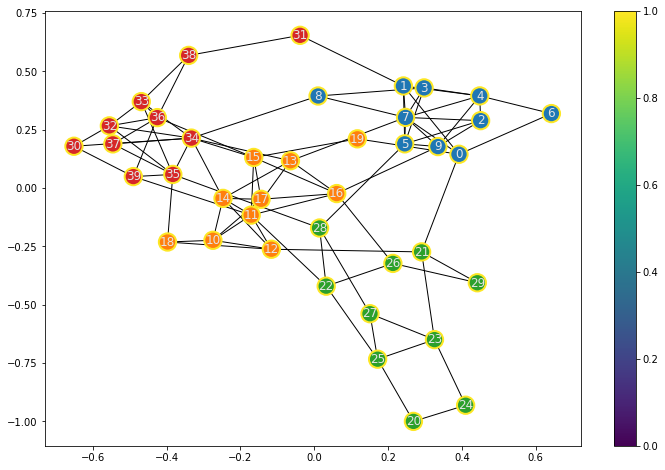

In [111]:
# Parameters
l = 4
k = 10
p_inner = .4
p_outer = .02
feature_mult = 1
feature_sigma = .2

# Show the graph
g = nx.planted_partition_graph(l, k, p_inner, p_outer)
labels = np.zeros((l * k, l))
for c in range(l):
    labels[range(c * k, (c + 1) * k), c] = 1
draw_network(g, labels=labels);

In [112]:
# Animate training
filename = VID.format(l=l, k=k, p_inner=p_inner, p_outer=p_outer,
                      f_mult=feature_mult, f_sigma=feature_sigma)
anim, (model, arrays, session) = build_train_animation((g, l, k), labels, feature_mult, feature_sigma)
widget = anim.save(filename)
#.to_jshtml()
#.to_html5_video()
#display(HTML(widget))
print("Animation saved to '{}'".format(filename))

Epoch: 0001 train_loss=1.39896 train_acc=0.00000 val_loss=1.37311 val_acc=0.03125 time=0.02926
Epoch: 0002 train_loss=1.36861 train_acc=0.00000 val_loss=1.34435 val_acc=0.15625 time=0.00157
Epoch: 0003 train_loss=1.33931 train_acc=0.12500 val_loss=1.31677 val_acc=0.43750 time=0.00225
Epoch: 0004 train_loss=1.31097 train_acc=0.37500 val_loss=1.29020 val_acc=0.50000 time=0.00200
Epoch: 0005 train_loss=1.28356 train_acc=0.37500 val_loss=1.26408 val_acc=0.65625 time=0.00262
Epoch: 0006 train_loss=1.25666 train_acc=0.62500 val_loss=1.23815 val_acc=0.84375 time=0.00180
Epoch: 0007 train_loss=1.23007 train_acc=0.75000 val_loss=1.21225 val_acc=0.90625 time=0.00239
Epoch: 0008 train_loss=1.20368 train_acc=0.75000 val_loss=1.18631 val_acc=0.96875 time=0.00370
Epoch: 0009 train_loss=1.17713 train_acc=0.87500 val_loss=1.16038 val_acc=1.00000 time=0.00259
Epoch: 0010 train_loss=1.15026 train_acc=0.87500 val_loss=1.13474 val_acc=1.00000 time=0.00171
Epoch: 0011 train_loss=1.12337 train_acc=0.87500 v

Epoch: 0089 train_loss=0.05984 train_acc=1.00000 val_loss=0.06691 val_acc=1.00000 time=0.00209
Epoch: 0090 train_loss=0.05803 train_acc=1.00000 val_loss=0.06553 val_acc=1.00000 time=0.00200
Epoch: 0091 train_loss=0.05630 train_acc=1.00000 val_loss=0.06421 val_acc=1.00000 time=0.00492
Epoch: 0092 train_loss=0.05465 train_acc=1.00000 val_loss=0.06294 val_acc=1.00000 time=0.00189
Epoch: 0093 train_loss=0.05306 train_acc=1.00000 val_loss=0.06171 val_acc=1.00000 time=0.00349
Epoch: 0094 train_loss=0.05154 train_acc=1.00000 val_loss=0.06054 val_acc=1.00000 time=0.00194
Epoch: 0095 train_loss=0.05009 train_acc=1.00000 val_loss=0.05941 val_acc=1.00000 time=0.00211
Epoch: 0096 train_loss=0.04870 train_acc=1.00000 val_loss=0.05832 val_acc=1.00000 time=0.00170
Epoch: 0097 train_loss=0.04737 train_acc=1.00000 val_loss=0.05728 val_acc=1.00000 time=0.00396
Epoch: 0098 train_loss=0.04609 train_acc=1.00000 val_loss=0.05628 val_acc=1.00000 time=0.00318
Epoch: 0099 train_loss=0.04486 train_acc=1.00000 v

Epoch: 0177 train_loss=0.01155 train_acc=1.00000 val_loss=0.02535 val_acc=1.00000 time=0.00177
Epoch: 0178 train_loss=0.01142 train_acc=1.00000 val_loss=0.02520 val_acc=1.00000 time=0.00165
Epoch: 0179 train_loss=0.01128 train_acc=1.00000 val_loss=0.02505 val_acc=1.00000 time=0.00193
Epoch: 0180 train_loss=0.01115 train_acc=1.00000 val_loss=0.02490 val_acc=1.00000 time=0.00515
Epoch: 0181 train_loss=0.01102 train_acc=1.00000 val_loss=0.02475 val_acc=1.00000 time=0.00193
Epoch: 0182 train_loss=0.01090 train_acc=1.00000 val_loss=0.02461 val_acc=1.00000 time=0.00190
Epoch: 0183 train_loss=0.01078 train_acc=1.00000 val_loss=0.02447 val_acc=1.00000 time=0.00196
Epoch: 0184 train_loss=0.01065 train_acc=1.00000 val_loss=0.02433 val_acc=1.00000 time=0.00419
Epoch: 0185 train_loss=0.01054 train_acc=1.00000 val_loss=0.02419 val_acc=1.00000 time=0.00172
Epoch: 0186 train_loss=0.01042 train_acc=1.00000 val_loss=0.02405 val_acc=1.00000 time=0.00169
Epoch: 0187 train_loss=0.01030 train_acc=1.00000 v

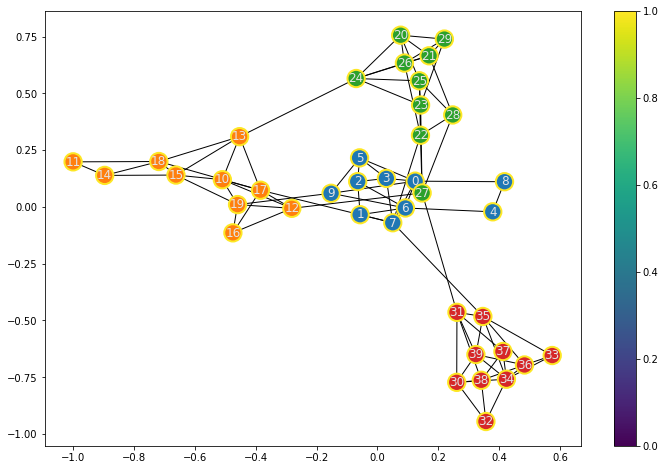

In [114]:
# Parameters
l = 4
k = 10
p_inner = .4
p_outer = .02
feature_mult = 1
feature_sigma = 1

# Show the graph
g = nx.planted_partition_graph(l, k, p_inner, p_outer)
labels = np.zeros((l * k, l))
for c in range(l):
    labels[range(c * k, (c + 1) * k), c] = 1
draw_network(g, labels=labels);

In [115]:
# Animate training
filename = VID.format(l=l, k=k, p_inner=p_inner, p_outer=p_outer,
                      f_mult=feature_mult, f_sigma=feature_sigma)
anim, (model, arrays, session) = build_train_animation((g, l, k), labels, feature_mult, feature_sigma)
widget = anim.save(filename)
#.to_jshtml()
#.to_html5_video()
#display(HTML(widget))
print("Animation saved to '{}'".format(filename))

Epoch: 0001 train_loss=1.25832 train_acc=0.37500 val_loss=1.26773 val_acc=0.43750 time=0.03395
Epoch: 0002 train_loss=1.22081 train_acc=0.37500 val_loss=1.23945 val_acc=0.50000 time=0.00194
Epoch: 0003 train_loss=1.18541 train_acc=0.37500 val_loss=1.21282 val_acc=0.50000 time=0.00297
Epoch: 0004 train_loss=1.15204 train_acc=0.37500 val_loss=1.18795 val_acc=0.53125 time=0.00165
Epoch: 0005 train_loss=1.12067 train_acc=0.62500 val_loss=1.16423 val_acc=0.53125 time=0.00168
Epoch: 0006 train_loss=1.09048 train_acc=0.62500 val_loss=1.14225 val_acc=0.53125 time=0.00247
Epoch: 0007 train_loss=1.06240 train_acc=0.62500 val_loss=1.12123 val_acc=0.53125 time=0.00165
Epoch: 0008 train_loss=1.03577 train_acc=0.62500 val_loss=1.10087 val_acc=0.53125 time=0.00216
Epoch: 0009 train_loss=1.01026 train_acc=0.62500 val_loss=1.08129 val_acc=0.53125 time=0.00229
Epoch: 0010 train_loss=0.98600 train_acc=0.62500 val_loss=1.06233 val_acc=0.53125 time=0.00168
Epoch: 0011 train_loss=0.96279 train_acc=0.62500 v

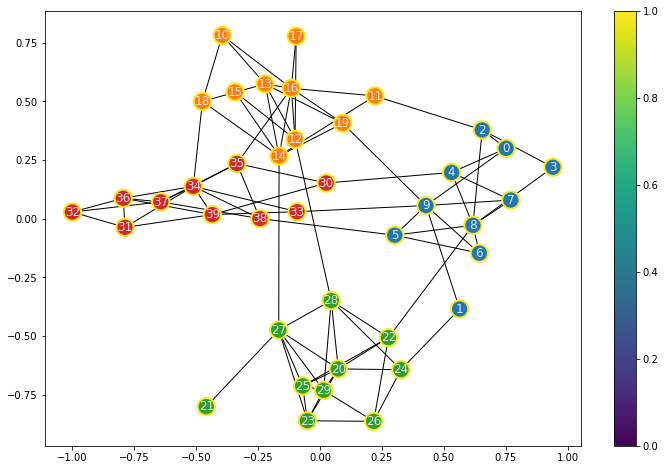

In [116]:
# Parameters
l = 4
k = 10
p_inner = .4
p_outer = .02
feature_mult = 5
feature_sigma = 1

# Show the graph
g = nx.planted_partition_graph(l, k, p_inner, p_outer)
labels = np.zeros((l * k, l))
for c in range(l):
    labels[range(c * k, (c + 1) * k), c] = 1
draw_network(g, labels=labels);

In [117]:
# Animate training
filename = VID.format(l=l, k=k, p_inner=p_inner, p_outer=p_outer,
                      f_mult=feature_mult, f_sigma=feature_sigma)
anim, (model, arrays, session) = build_train_animation((g, l, k), labels, feature_mult, feature_sigma)
widget = anim.save(filename)
#.to_jshtml()
#.to_html5_video()
#display(HTML(widget))
print("Animation saved to '{}'".format(filename))

Epoch: 0001 train_loss=1.58224 train_acc=0.00000 val_loss=1.53656 val_acc=0.18750 time=0.03936
Epoch: 0002 train_loss=1.52516 train_acc=0.12500 val_loss=1.49169 val_acc=0.18750 time=0.00212
Epoch: 0003 train_loss=1.47509 train_acc=0.25000 val_loss=1.45069 val_acc=0.21875 time=0.00271
Epoch: 0004 train_loss=1.42925 train_acc=0.25000 val_loss=1.41225 val_acc=0.25000 time=0.00259
Epoch: 0005 train_loss=1.38572 train_acc=0.25000 val_loss=1.37786 val_acc=0.34375 time=0.00210
Epoch: 0006 train_loss=1.34740 train_acc=0.50000 val_loss=1.34772 val_acc=0.59375 time=0.00179
Epoch: 0007 train_loss=1.31407 train_acc=0.50000 val_loss=1.32092 val_acc=0.59375 time=0.00339
Epoch: 0008 train_loss=1.28434 train_acc=0.75000 val_loss=1.29496 val_acc=0.65625 time=0.00202
Epoch: 0009 train_loss=1.25548 train_acc=0.75000 val_loss=1.26890 val_acc=0.68750 time=0.00191
Epoch: 0010 train_loss=1.22659 train_acc=0.75000 val_loss=1.24312 val_acc=0.71875 time=0.00208
Epoch: 0011 train_loss=1.19775 train_acc=0.75000 v

Epoch: 0088 train_loss=0.04411 train_acc=1.00000 val_loss=0.06964 val_acc=1.00000 time=0.00239
Epoch: 0089 train_loss=0.04263 train_acc=1.00000 val_loss=0.06835 val_acc=1.00000 time=0.00209
Epoch: 0090 train_loss=0.04121 train_acc=1.00000 val_loss=0.06713 val_acc=1.00000 time=0.00320
Epoch: 0091 train_loss=0.03987 train_acc=1.00000 val_loss=0.06597 val_acc=1.00000 time=0.00184
Epoch: 0092 train_loss=0.03860 train_acc=1.00000 val_loss=0.06487 val_acc=1.00000 time=0.00211
Epoch: 0093 train_loss=0.03739 train_acc=1.00000 val_loss=0.06382 val_acc=1.00000 time=0.00205
Epoch: 0094 train_loss=0.03624 train_acc=1.00000 val_loss=0.06281 val_acc=1.00000 time=0.00260
Epoch: 0095 train_loss=0.03515 train_acc=1.00000 val_loss=0.06185 val_acc=1.00000 time=0.00234
Epoch: 0096 train_loss=0.03411 train_acc=1.00000 val_loss=0.06093 val_acc=1.00000 time=0.00314
Epoch: 0097 train_loss=0.03311 train_acc=1.00000 val_loss=0.06004 val_acc=1.00000 time=0.00187
Epoch: 0098 train_loss=0.03216 train_acc=1.00000 v

Epoch: 0176 train_loss=0.00796 train_acc=1.00000 val_loss=0.03395 val_acc=1.00000 time=0.00198
Epoch: 0177 train_loss=0.00787 train_acc=1.00000 val_loss=0.03381 val_acc=1.00000 time=0.00214
Epoch: 0178 train_loss=0.00778 train_acc=1.00000 val_loss=0.03368 val_acc=1.00000 time=0.00223
Epoch: 0179 train_loss=0.00769 train_acc=1.00000 val_loss=0.03355 val_acc=1.00000 time=0.00222
Epoch: 0180 train_loss=0.00760 train_acc=1.00000 val_loss=0.03342 val_acc=1.00000 time=0.00297
Epoch: 0181 train_loss=0.00751 train_acc=1.00000 val_loss=0.03329 val_acc=1.00000 time=0.00203
Epoch: 0182 train_loss=0.00742 train_acc=1.00000 val_loss=0.03316 val_acc=1.00000 time=0.00195
Epoch: 0183 train_loss=0.00734 train_acc=1.00000 val_loss=0.03303 val_acc=1.00000 time=0.00201
Epoch: 0184 train_loss=0.00726 train_acc=1.00000 val_loss=0.03291 val_acc=1.00000 time=0.00202
Epoch: 0185 train_loss=0.00717 train_acc=1.00000 val_loss=0.03279 val_acc=1.00000 time=0.00187
Epoch: 0186 train_loss=0.00709 train_acc=1.00000 v

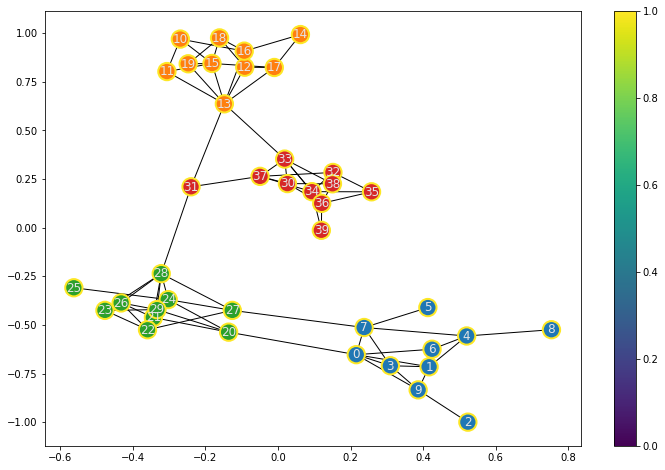

In [118]:
# Parameters
l = 4
k = 10
p_inner = .4
p_outer = .02
feature_mult = 1
feature_sigma = 100

# Show the graph
g = nx.planted_partition_graph(l, k, p_inner, p_outer)
labels = np.zeros((l * k, l))
for c in range(l):
    labels[range(c * k, (c + 1) * k), c] = 1
draw_network(g, labels=labels);

In [119]:
# Animate training
filename = VID.format(l=l, k=k, p_inner=p_inner, p_outer=p_outer,
                      f_mult=feature_mult, f_sigma=feature_sigma)
anim, (model, arrays, session) = build_train_animation((g, l, k), labels, feature_mult, feature_sigma)
widget = anim.save(filename)
#.to_jshtml()
#.to_html5_video()
#display(HTML(widget))
print("Animation saved to '{}'".format(filename))

Epoch: 0001 train_loss=2.52694 train_acc=0.12500 val_loss=2.26686 val_acc=0.25000 time=0.04245
Epoch: 0002 train_loss=2.33006 train_acc=0.25000 val_loss=2.11181 val_acc=0.25000 time=0.00194
Epoch: 0003 train_loss=2.16747 train_acc=0.25000 val_loss=1.97100 val_acc=0.25000 time=0.00169
Epoch: 0004 train_loss=2.02310 train_acc=0.25000 val_loss=1.84048 val_acc=0.25000 time=0.00297
Epoch: 0005 train_loss=1.88881 train_acc=0.25000 val_loss=1.71943 val_acc=0.25000 time=0.00163
Epoch: 0006 train_loss=1.76281 train_acc=0.25000 val_loss=1.60617 val_acc=0.25000 time=0.00166
Epoch: 0007 train_loss=1.64496 train_acc=0.25000 val_loss=1.49937 val_acc=0.25000 time=0.00170
Epoch: 0008 train_loss=1.53409 train_acc=0.25000 val_loss=1.39794 val_acc=0.46875 time=0.00169
Epoch: 0009 train_loss=1.42921 train_acc=0.37500 val_loss=1.30142 val_acc=0.50000 time=0.00176
Epoch: 0010 train_loss=1.32977 train_acc=0.50000 val_loss=1.21005 val_acc=0.50000 time=0.00167
Epoch: 0011 train_loss=1.23536 train_acc=0.50000 v

Epoch: 0089 train_loss=0.04319 train_acc=1.00000 val_loss=0.14774 val_acc=0.93750 time=0.00226
Epoch: 0090 train_loss=0.04177 train_acc=1.00000 val_loss=0.14650 val_acc=0.93750 time=0.00166
Epoch: 0091 train_loss=0.04042 train_acc=1.00000 val_loss=0.14533 val_acc=0.93750 time=0.00183
Epoch: 0092 train_loss=0.03913 train_acc=1.00000 val_loss=0.14423 val_acc=0.93750 time=0.00185
Epoch: 0093 train_loss=0.03790 train_acc=1.00000 val_loss=0.14321 val_acc=0.93750 time=0.00167
Epoch: 0094 train_loss=0.03673 train_acc=1.00000 val_loss=0.14225 val_acc=0.93750 time=0.00163
Epoch: 0095 train_loss=0.03560 train_acc=1.00000 val_loss=0.14136 val_acc=0.93750 time=0.00211
Epoch: 0096 train_loss=0.03453 train_acc=1.00000 val_loss=0.14055 val_acc=0.93750 time=0.00184
Epoch: 0097 train_loss=0.03351 train_acc=1.00000 val_loss=0.13979 val_acc=0.93750 time=0.00221
Epoch: 0098 train_loss=0.03253 train_acc=1.00000 val_loss=0.13907 val_acc=0.93750 time=0.00175
Epoch: 0099 train_loss=0.03159 train_acc=1.00000 v

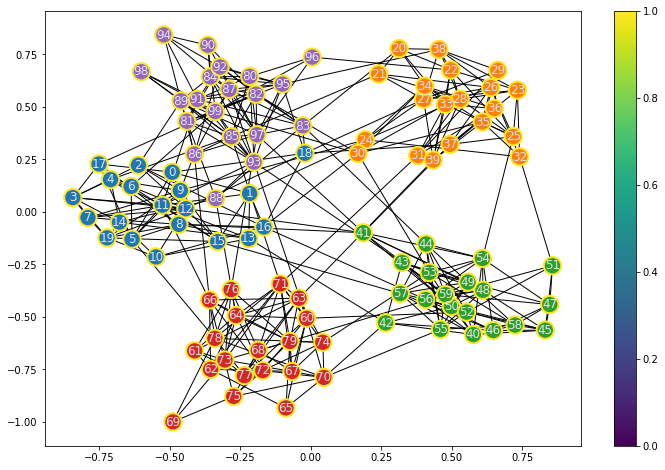

In [120]:
# Parameters
l = 5
k = 20
p_inner = .4
p_outer = .01
feature_mult = 1
feature_sigma = 1

# Show the graph
g = nx.planted_partition_graph(l, k, p_inner, p_outer)
labels = np.zeros((l * k, l))
for c in range(l):
    labels[range(c * k, (c + 1) * k), c] = 1
draw_network(g, labels=labels);

In [121]:
# Animate training
filename = VID.format(l=l, k=k, p_inner=p_inner, p_outer=p_outer,
                      f_mult=feature_mult, f_sigma=feature_sigma)
anim, (model, arrays, session) = build_train_animation((g, l, k), labels, feature_mult, feature_sigma)
widget = anim.save(filename)
#.to_jshtml()
#.to_html5_video()
#display(HTML(widget))
print("Animation saved to '{}'".format(filename))

Epoch: 0001 train_loss=1.67171 train_acc=0.05000 val_loss=1.60056 val_acc=0.20000 time=0.04561
Epoch: 0002 train_loss=1.64388 train_acc=0.20000 val_loss=1.57591 val_acc=0.20000 time=0.00235
Epoch: 0003 train_loss=1.61733 train_acc=0.20000 val_loss=1.55229 val_acc=0.20000 time=0.00285
Epoch: 0004 train_loss=1.59150 train_acc=0.20000 val_loss=1.52968 val_acc=0.20000 time=0.00278
Epoch: 0005 train_loss=1.56639 train_acc=0.20000 val_loss=1.50778 val_acc=0.21250 time=0.00203
Epoch: 0006 train_loss=1.54175 train_acc=0.20000 val_loss=1.48629 val_acc=0.26250 time=0.00304
Epoch: 0007 train_loss=1.51740 train_acc=0.25000 val_loss=1.46517 val_acc=0.28750 time=0.00284
Epoch: 0008 train_loss=1.49324 train_acc=0.30000 val_loss=1.44428 val_acc=0.30000 time=0.00247
Epoch: 0009 train_loss=1.46937 train_acc=0.35000 val_loss=1.42328 val_acc=0.31250 time=0.00250
Epoch: 0010 train_loss=1.44555 train_acc=0.35000 val_loss=1.40225 val_acc=0.32500 time=0.00238
Epoch: 0011 train_loss=1.42185 train_acc=0.35000 v

Epoch: 0088 train_loss=0.16029 train_acc=1.00000 val_loss=0.23374 val_acc=0.95000 time=0.00453
Epoch: 0089 train_loss=0.15560 train_acc=1.00000 val_loss=0.22936 val_acc=0.95000 time=0.00252
Epoch: 0090 train_loss=0.15104 train_acc=1.00000 val_loss=0.22509 val_acc=0.95000 time=0.00488
Epoch: 0091 train_loss=0.14660 train_acc=1.00000 val_loss=0.22091 val_acc=0.95000 time=0.00321
Epoch: 0092 train_loss=0.14228 train_acc=1.00000 val_loss=0.21686 val_acc=0.95000 time=0.00891
Epoch: 0093 train_loss=0.13809 train_acc=1.00000 val_loss=0.21290 val_acc=0.95000 time=0.00209
Epoch: 0094 train_loss=0.13401 train_acc=1.00000 val_loss=0.20903 val_acc=0.95000 time=0.00204
Epoch: 0095 train_loss=0.13006 train_acc=1.00000 val_loss=0.20526 val_acc=0.95000 time=0.00324
Epoch: 0096 train_loss=0.12622 train_acc=1.00000 val_loss=0.20158 val_acc=0.96250 time=0.00823
Epoch: 0097 train_loss=0.12248 train_acc=1.00000 val_loss=0.19800 val_acc=0.96250 time=0.00370
Epoch: 0098 train_loss=0.11884 train_acc=1.00000 v

Epoch: 0175 train_loss=0.01962 train_acc=1.00000 val_loss=0.08695 val_acc=0.98750 time=0.00233
Epoch: 0176 train_loss=0.01932 train_acc=1.00000 val_loss=0.08649 val_acc=0.98750 time=0.00277
Epoch: 0177 train_loss=0.01902 train_acc=1.00000 val_loss=0.08604 val_acc=0.98750 time=0.00234
Epoch: 0178 train_loss=0.01874 train_acc=1.00000 val_loss=0.08559 val_acc=0.98750 time=0.00221
Epoch: 0179 train_loss=0.01846 train_acc=1.00000 val_loss=0.08516 val_acc=0.98750 time=0.00244
Epoch: 0180 train_loss=0.01819 train_acc=1.00000 val_loss=0.08474 val_acc=0.98750 time=0.00476
Epoch: 0181 train_loss=0.01792 train_acc=1.00000 val_loss=0.08432 val_acc=0.98750 time=0.00320
Epoch: 0182 train_loss=0.01766 train_acc=1.00000 val_loss=0.08391 val_acc=0.98750 time=0.00222
Epoch: 0183 train_loss=0.01741 train_acc=1.00000 val_loss=0.08351 val_acc=0.98750 time=0.00266
Epoch: 0184 train_loss=0.01716 train_acc=1.00000 val_loss=0.08311 val_acc=0.98750 time=0.00364
Epoch: 0185 train_loss=0.01692 train_acc=1.00000 v

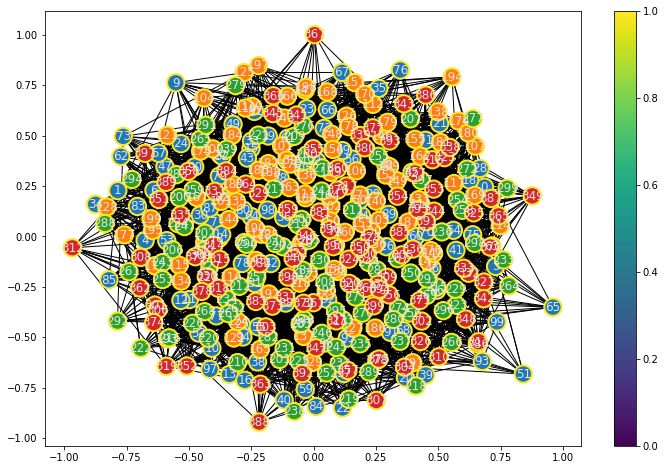

In [122]:
# Parameters
l = 4
k = 100
p_inner = .1
p_outer = .05
feature_mult = 1
feature_sigma = 1

# Show the graph
g = nx.planted_partition_graph(l, k, p_inner, p_outer)
labels = np.zeros((l * k, l))
for c in range(l):
    labels[range(c * k, (c + 1) * k), c] = 1
draw_network(g, labels=labels);

In [123]:
# Animate training
filename = VID.format(l=l, k=k, p_inner=p_inner, p_outer=p_outer,
                      f_mult=feature_mult, f_sigma=feature_sigma)
anim, (model, arrays, session) = build_train_animation((g, l, k), labels, feature_mult, feature_sigma)
widget = anim.save(filename)
#.to_jshtml()
#.to_html5_video()
#display(HTML(widget))
print("Animation saved to '{}'".format(filename))

Epoch: 0001 train_loss=1.40630 train_acc=0.25000 val_loss=1.40951 val_acc=0.20000 time=0.06512
Epoch: 0002 train_loss=1.39926 train_acc=0.27500 val_loss=1.40466 val_acc=0.21250 time=0.00542
Epoch: 0003 train_loss=1.39327 train_acc=0.28750 val_loss=1.40072 val_acc=0.21875 time=0.00470
Epoch: 0004 train_loss=1.38822 train_acc=0.28750 val_loss=1.39746 val_acc=0.22813 time=0.00449
Epoch: 0005 train_loss=1.38395 train_acc=0.28750 val_loss=1.39470 val_acc=0.24062 time=0.00456
Epoch: 0006 train_loss=1.38023 train_acc=0.28750 val_loss=1.39235 val_acc=0.25000 time=0.00452
Epoch: 0007 train_loss=1.37699 train_acc=0.30000 val_loss=1.39028 val_acc=0.24688 time=0.00450
Epoch: 0008 train_loss=1.37405 train_acc=0.27500 val_loss=1.38850 val_acc=0.25313 time=0.00435
Epoch: 0009 train_loss=1.37144 train_acc=0.26250 val_loss=1.38691 val_acc=0.26562 time=0.00437
Epoch: 0010 train_loss=1.36912 train_acc=0.28750 val_loss=1.38545 val_acc=0.28125 time=0.00449
Epoch: 0011 train_loss=1.36703 train_acc=0.23750 v

Epoch: 0088 train_loss=1.15761 train_acc=0.51250 val_loss=1.28623 val_acc=0.42188 time=0.00574
Epoch: 0089 train_loss=1.15474 train_acc=0.52500 val_loss=1.28566 val_acc=0.42188 time=0.01028
Epoch: 0090 train_loss=1.15187 train_acc=0.51250 val_loss=1.28516 val_acc=0.41875 time=0.00518
Epoch: 0091 train_loss=1.14902 train_acc=0.51250 val_loss=1.28471 val_acc=0.42188 time=0.00620
Epoch: 0092 train_loss=1.14618 train_acc=0.51250 val_loss=1.28431 val_acc=0.42500 time=0.00511
Epoch: 0093 train_loss=1.14337 train_acc=0.51250 val_loss=1.28394 val_acc=0.42812 time=0.00624
Epoch: 0094 train_loss=1.14060 train_acc=0.51250 val_loss=1.28360 val_acc=0.42500 time=0.00514
Epoch: 0095 train_loss=1.13785 train_acc=0.52500 val_loss=1.28327 val_acc=0.42500 time=0.00458
Epoch: 0096 train_loss=1.13515 train_acc=0.52500 val_loss=1.28298 val_acc=0.42188 time=0.00523
Epoch: 0097 train_loss=1.13252 train_acc=0.52500 val_loss=1.28264 val_acc=0.42812 time=0.00646
Epoch: 0098 train_loss=1.12992 train_acc=0.52500 v